<a href="https://colab.research.google.com/github/Luviz/se_covid_data/blob/main/Swe_Covid_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid Data publish by FOHM
## Confirmed cases in Sweden - daily update 

[src](https://www.folkhalsomyndigheten.se/smittskydd-beredskap/utbrott/aktuella-utbrott/covid-19/statistik-och-analyser/bekraftade-fall-i-sverige/)
& 
[xlsx](https://www.arcgis.com/sharing/rest/content/items/b5e7488e117749c19881cce45db13f7e/data)


In [1]:
!curl -L https://www.arcgis.com/sharing/rest/content/items/b5e7488e117749c19881cce45db13f7e/data -o ./covid-data.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1746k  100 1746k    0     0  3135k      0 --:--:-- --:--:-- --:--:-- 7070k


In [2]:
# !pip3 install --upgrade openpyxl 1> /dev/null
import pandas as pd
from matplotlib import pyplot as plt 
from datetime import datetime

filename = "covid-data.xlsx"

In [3]:
excel = pd.ExcelFile("./covid-data.xlsx")
page_num_cases, page_num_death, page_num_icu = excel.sheet_names[:3]
pubdate = excel.sheet_names[-1] 
print(f"Published on: {pubdate}")

Published on: FOHM 23 Dec 2021


In [4]:
cases = excel.parse(page_num_cases)[["Statistikdatum", "Totalt_antal_fall"]]
deaths = excel.parse(page_num_death)[:-1] # the last object was a string
excel.close()

In [5]:
deaths["Datum_avliden"] = pd.to_datetime(deaths["Datum_avliden"])

In [6]:
df = cases.merge(
      deaths, how="left", 
      left_on="Statistikdatum", 
      right_on="Datum_avliden"
    ).drop("Datum_avliden", axis=1).fillna(0)
df["Antal_avlidna"] = df["Antal_avlidna"].astype(int)
df.set_index("Statistikdatum", inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


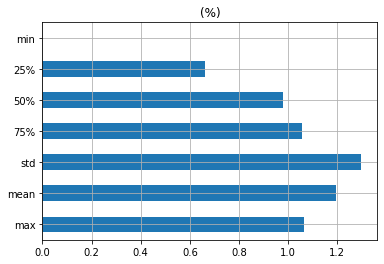

In [7]:
columns= ["max", "mean", "std", "75%", "50%", "25%", "min"]
_ = df.describe().apply(
      lambda a: 100*a["Antal_avlidna"] / a["Totalt_antal_fall"], axis=1
    )[columns].plot.barh(grid=True, title="(%)")

# Overview on the last 30 days

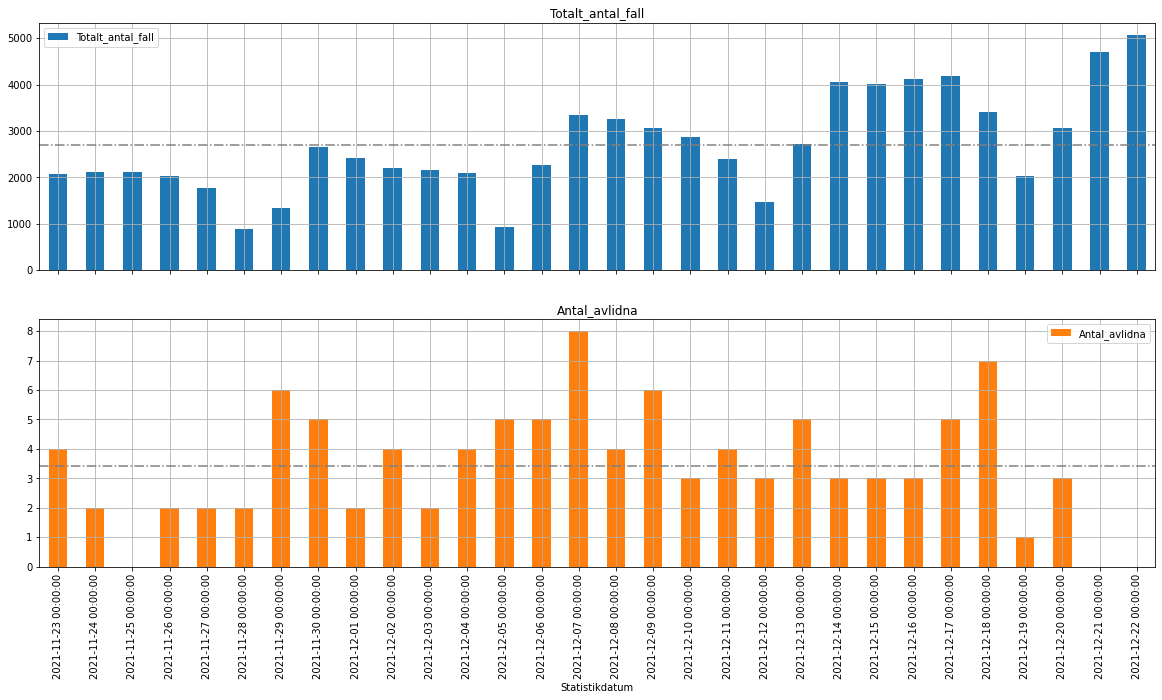

In [8]:
last_mouth = df.tail(30)
mean_cases,mean_deaths = last_mouth.mean()
ax = last_mouth.plot.bar(figsize=(20,10), subplots=True, grid=True)
ax[0].axhline(mean_cases, color="grey", linestyle="-.")
ax[1].axhline(mean_deaths, color="grey", linestyle="-.")

# Overview from start

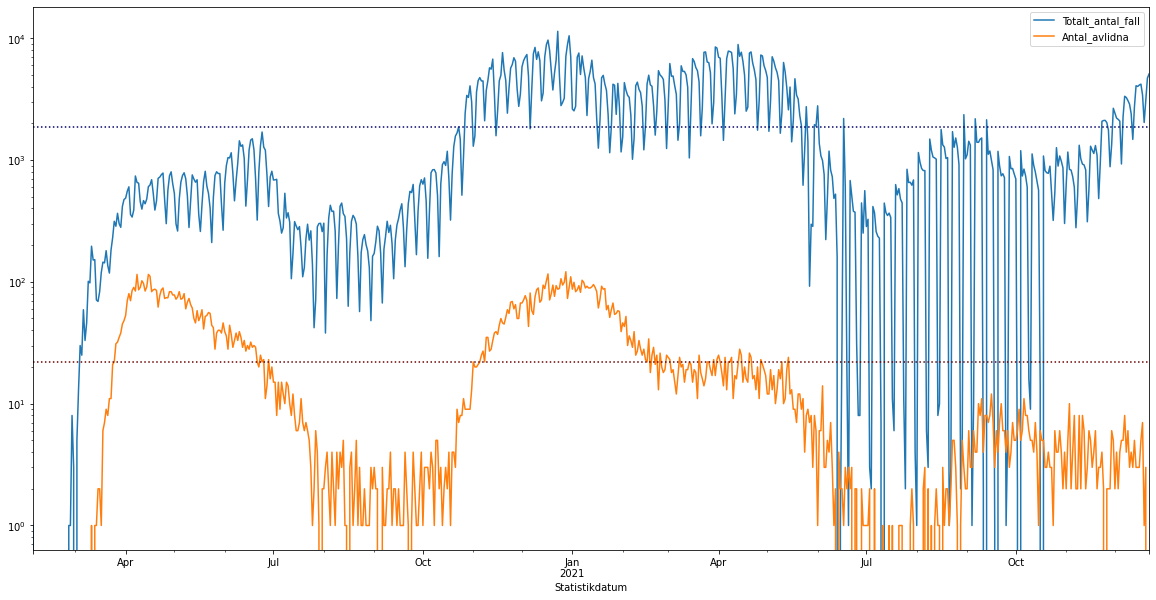

In [9]:
ax= df.plot(logy=True, figsize=(20,10))

mean_cases, mean_deaths = df.mean()
_ = ax.axhline(mean_cases, color="#000068", linestyle=":")
_ = ax.axhline(mean_deaths, color="#680000", linestyle=":")
# mean_deaths

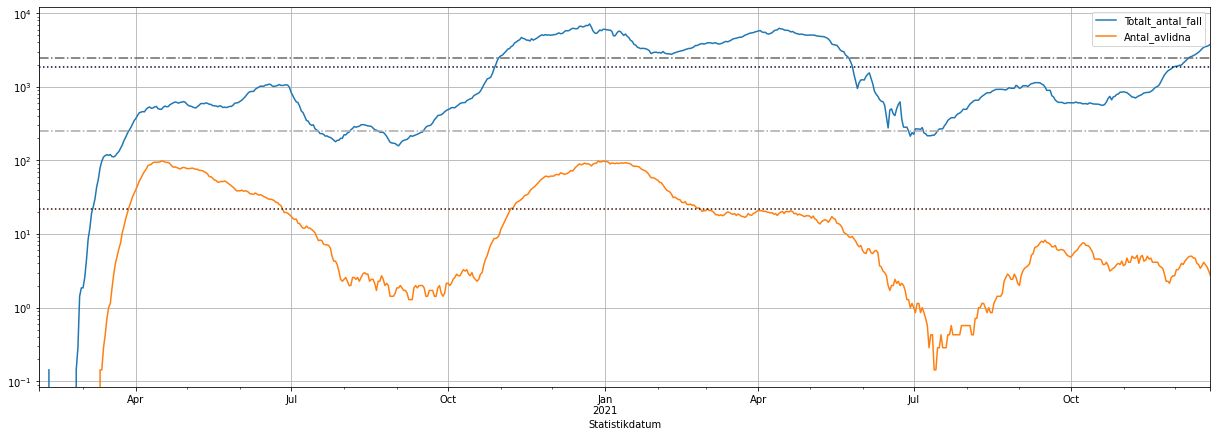

In [10]:
ax = df.rolling(7).mean().plot(logy=True, figsize=(21, 7), grid=True)

_ = ax.axhline(2500, color="#686868", linestyle="-.")
_ = ax.axhline(250,  color="#A8A8A8", linestyle="-.")

mean_cases, mean_deaths = df.mean()

_ = ax.axhline(mean_cases,  color="#000838", linestyle=":")
_ = ax.axhline(mean_deaths, color="#380800", linestyle=":")


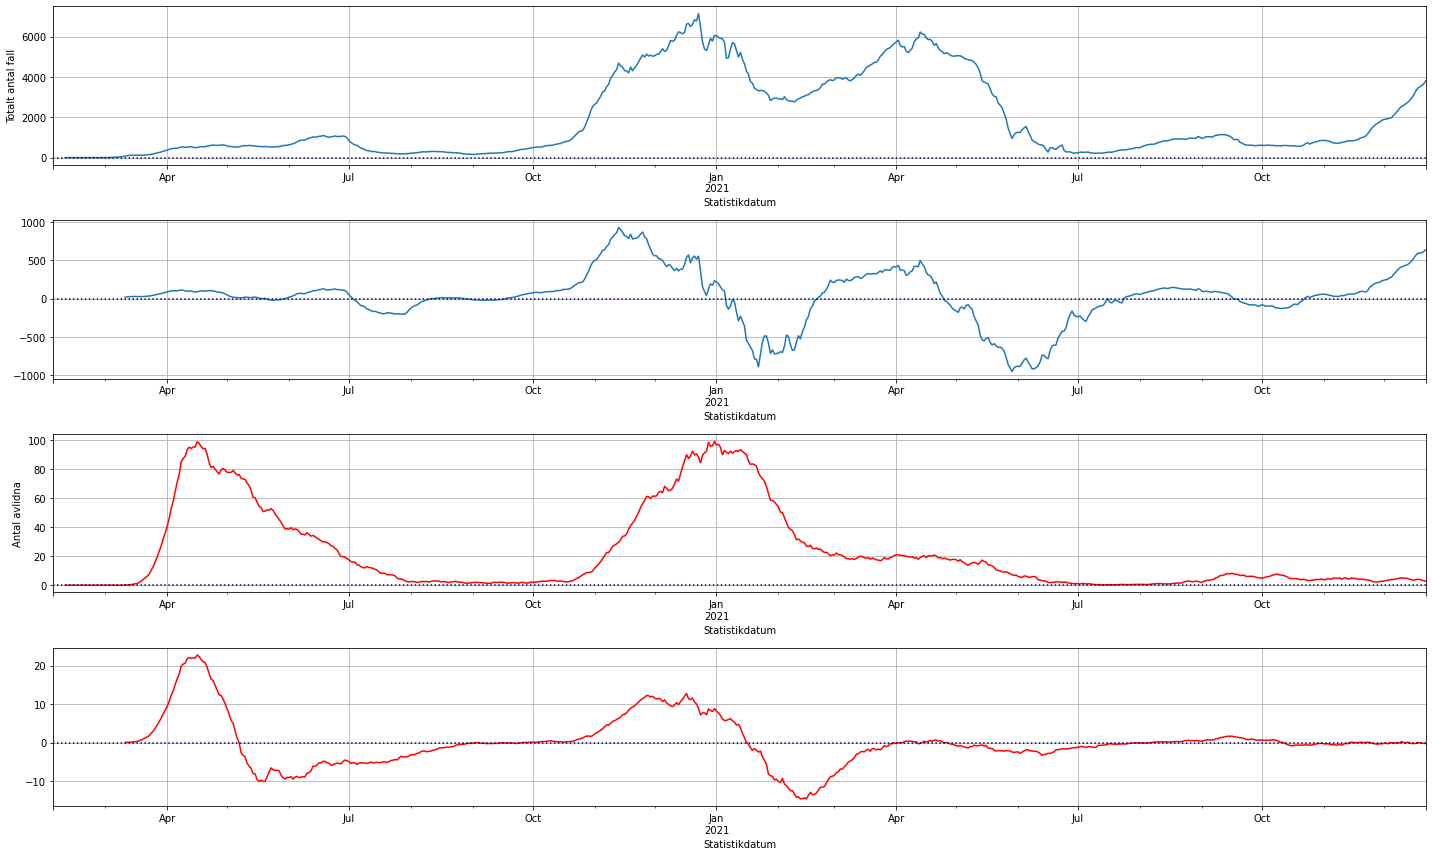

In [11]:
fig, ax = plt.subplots(4)
fig.set_size_inches(20, 12)
fig.set_tight_layout(True)

df["Totalt_antal_fall"].rolling(7).mean()\
    .plot(ax=ax[0], grid=True, ylabel="Totalt antal fall")

df["Totalt_antal_fall"].rolling(30).mean().diff(7)\
    .plot(ax=ax[1], grid=True, )

df["Antal_avlidna"].rolling(7).mean()\
    .plot(ax=ax[2], color="r", grid=True,  ylabel="Antal avlidna")
    
df["Antal_avlidna"].rolling(30).mean().diff(7)\
    .plot(ax=ax[3], color="r", grid=True)

for a in ax:
    a.axhline(0, color="#000068", linestyle=":")

# Effect of vaccine on covid cases and deaths

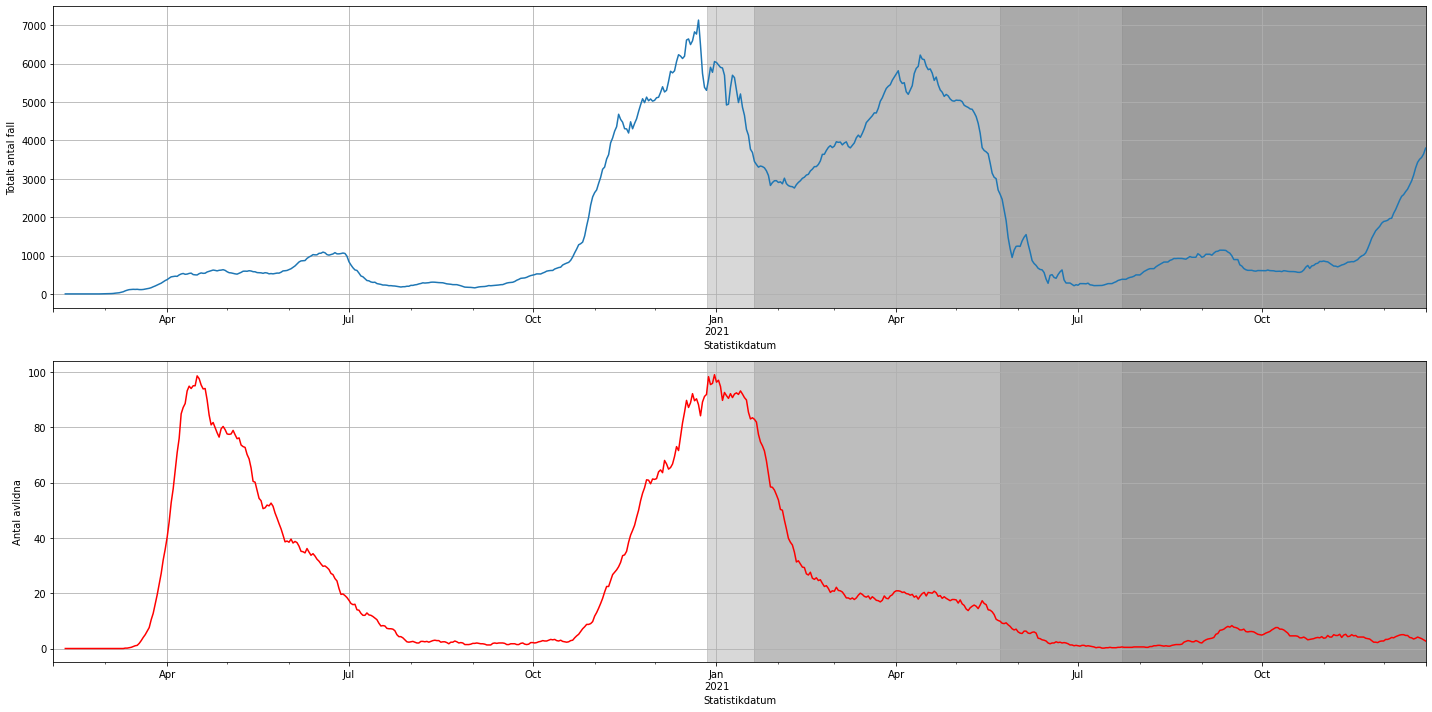

In [12]:
fig, ax = plt.subplots(2)
fig.set_size_inches(20, 10)
fig.set_tight_layout(True)

tot = df["Totalt_antal_fall"].rolling(7).mean()\
        .plot(ax=ax[0], grid=True, ylabel="Totalt antal fall")
dea = df["Antal_avlidna"].rolling(7).mean()\
        .plot(ax=ax[1], color="r", grid=True,  ylabel="Antal avlidna")

# src https://en.wikipedia.org/wiki/COVID-19_vaccination_in_Sweden
options = {"color":"grey", "alpha":0.3}
for a in [tot, dea]:
  # Pfizer deployment  
  a.axvspan(datetime(2020,12,27), datetime.now(), **options) 
  # In late January 2021, around 1,000 people, all healthcare workers, were given doses of the Moderna vaccine
  a.axvspan(datetime(2021, 1,20), datetime.now(), **options)  
  # ~ ppl in 60~55 got Vaccinated
  a.axvspan(datetime(2021, 5,23), datetime.now(), **options)  
  # when I got Vaccinated 
  a.axvspan(datetime(2021, 7,23), datetime.now(), **options)






# Covid Waves

[src - socialstyrelsen](https://www.socialstyrelsen.se/statistik-och-data/statistik/statistik-om-covid-19/)

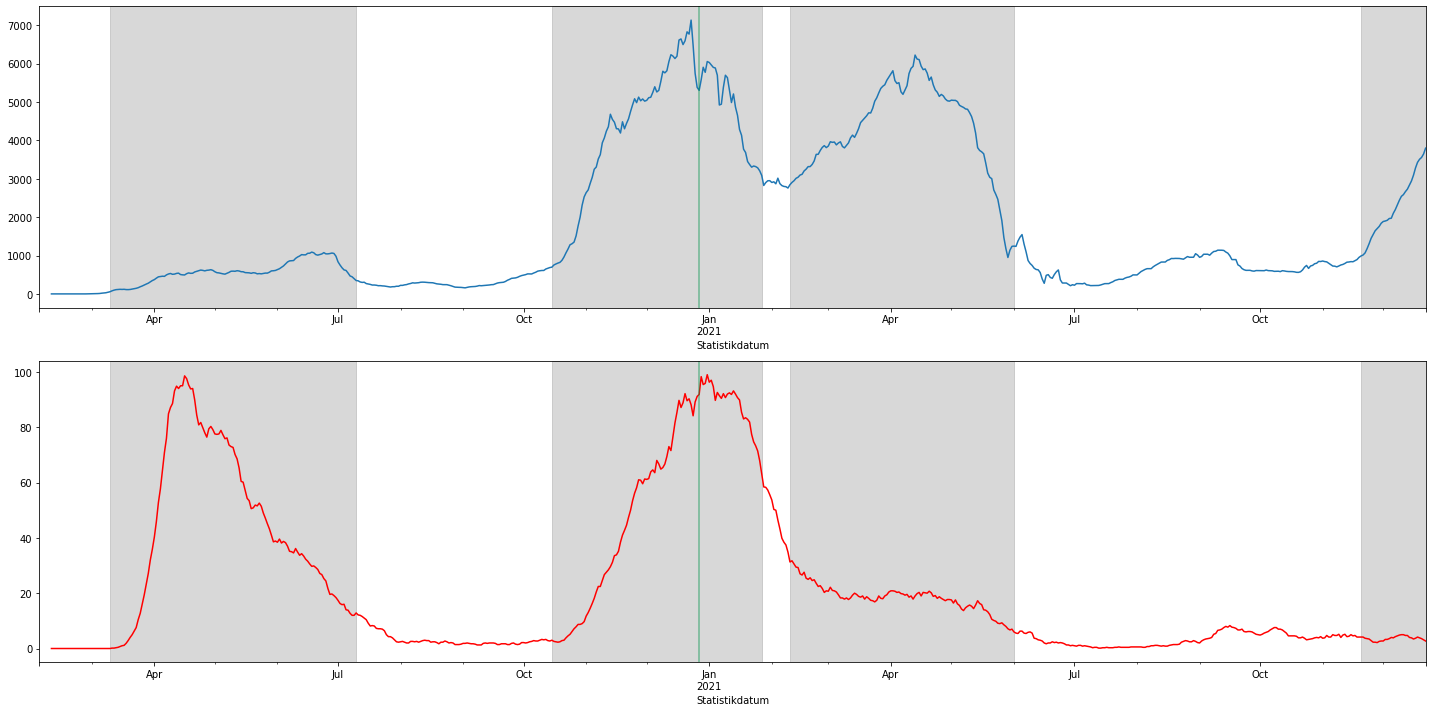

In [13]:
fig, ax = plt.subplots(2)
fig.set_size_inches(20, 10)
fig.set_tight_layout(True)

data = df.rolling(7).mean()
p_config = {"logy":False}

data["Totalt_antal_fall"].plot(ax=ax[0], **p_config)
data["Antal_avlidna"].plot(ax=ax[1], color='r', **p_config)

for a in ax:
  a.axvspan(datetime(2020, 3,10), datetime(2020, 7,10), **options) ## 1st wave
  a.axvspan(datetime(2020,10,15), datetime(2021, 1,27), **options) ## 2nd wave
  a.axvspan(datetime(2021, 2,10), datetime(2021, 6, 1), **options) ## 3rd wave
  a.axvspan(datetime(2021,11,20), datetime.now(), **options)       ## 4th wave
  a.axvline(datetime(2020,12,27), color="#009349", alpha=0.5) # Pfizer deployment  


## Fist wave


In [14]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

def get_grid():
  fig = plt.figure(constrained_layout=True)
  gs = fig.add_gridspec(3, 3)

  ax_box = fig.add_subplot(gs[:,2])
  ax_1 = fig.add_subplot(gs[0,:-1])
  ax_2 = fig.add_subplot(gs[1,:-1])
  ax_kde_1 = fig.add_subplot(gs[2,0])
  ax_kde_2 = fig.add_subplot(gs[2,1])
  
  ax_box.yaxis.set_minor_locator(MultipleLocator(250))
  ax_box.grid(which='minor', color='#CCCCCC', linestyle='--')

  return fig, ax_1, ax_2, ax_box, ax_kde_1, ax_kde_2


In [15]:
def draw_data(df:pd.DataFrame, start:datetime, end:datetime, rolling=7, fig_size=(15,7)):
    data = df[start:end].rolling(rolling).mean() 
    fig, ax_cases, ax_deaths, ax_box, ax_kde_1, ax_kde_2 = get_grid()
    fig.set_size_inches(*fig_size)

    p_config = {"logy":False, "grid":True}

    _ = data.plot(subplots= True, ax=[ax_cases, ax_deaths], **p_config, title="Fourth Wave")
    _ = df[start:end].plot.box(grid=True, ax=ax_box, logy=True)
    _ = df[start:end].plot.kde(grid=True, subplots=True, ax=[ax_kde_1, ax_kde_2])

    sum_cases, sum_deaths = df[start:end].sum()
    print(f"likellyness of death: {(100*sum_deaths/sum_cases):.2f}%")

likellyness of death: 7.78%


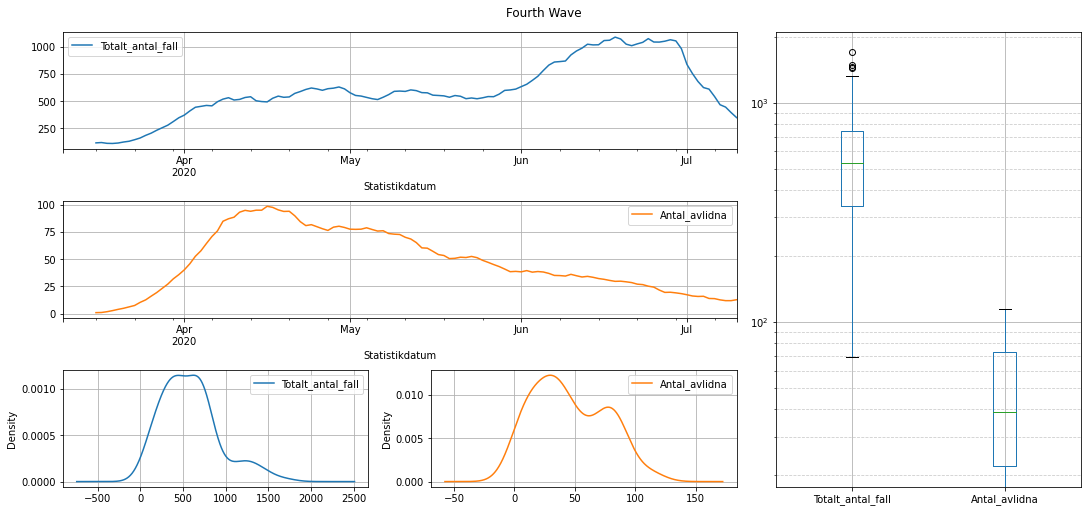

In [16]:
start, end = datetime(2020, 3,10), datetime(2020, 7,10)
draw_data(df, start, end)

## Second Wave 

likellyness of death: 1.33%


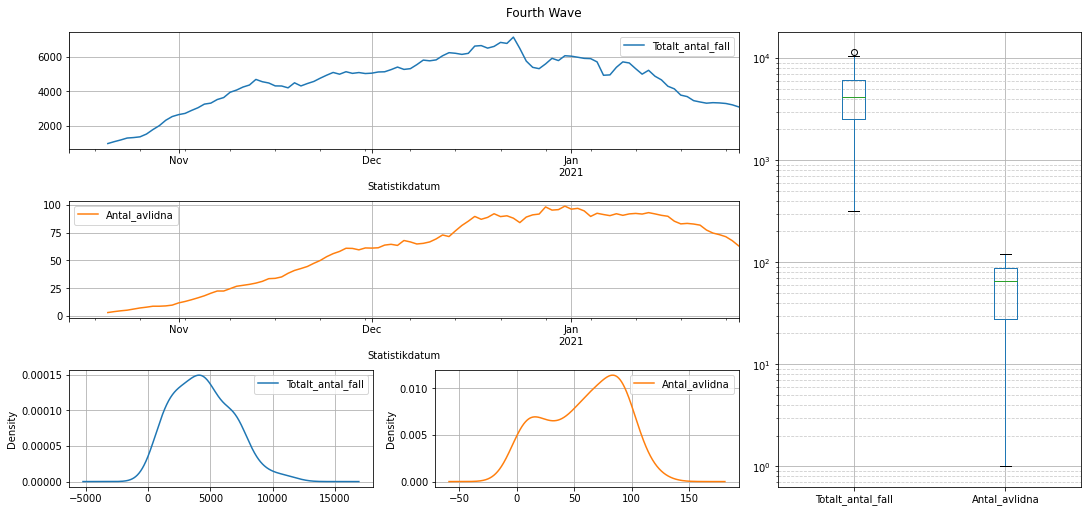

In [17]:
start, end = datetime(2020,10,15), datetime(2021, 1,27)
draw_data(df, start, end)


## Third Wave

likellyness of death: 0.42%


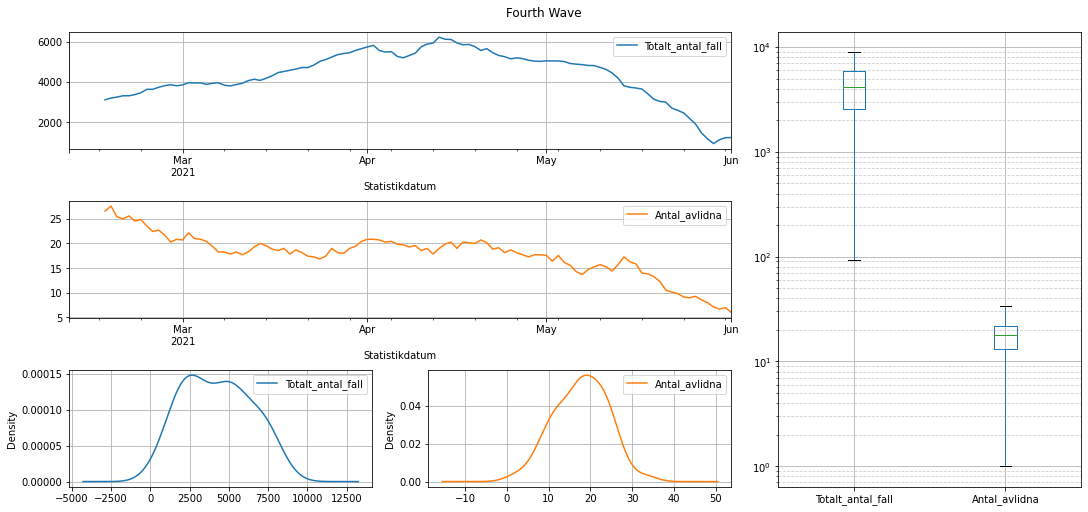

In [18]:
start, end = datetime(2021, 2,10), datetime(2021, 6, 1)
draw_data(df, start, end)


## Fourth Wave 

likellyness of death: 0.13%


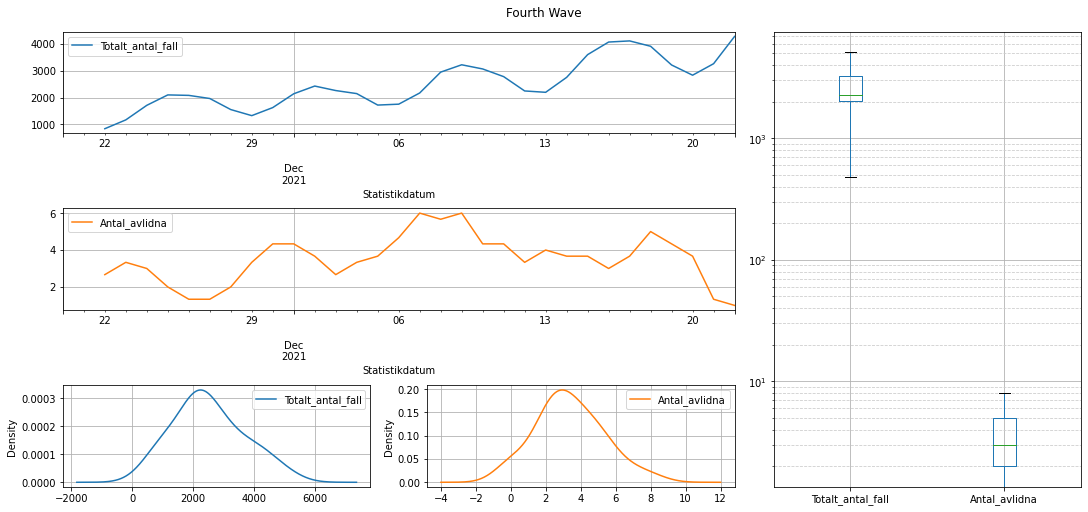

In [19]:
start, end = datetime(2021,11,20), datetime.now()
draw_data(df, start, end, rolling=3)
